# 04 - Client Score Rating 

In [37]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    balanced_accuracy_score
)
import imblearn
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import pickle
logging.getLogger().setLevel(logging.CRITICAL)


In [38]:
# Packages version
print(f'pandas: {pd.__version__}')
print(f'numpy: {np.__version__}')
print(f'matplotlib: {matplotlib.__version__}')
print(f'seaborn: {sns.__version__}')
print(f'sklearn: {sklearn.__version__}')
print(f'imblearn: {imblearn.__version__}')
print(f'logging: {logging.__version__}')

pandas: 2.3.1
numpy: 2.0.2
matplotlib: 3.9.4
seaborn: 0.13.2
sklearn: 1.6.1
imblearn: 0.12.4
logging: 0.5.1.2


## **✅ Evaluation**  

In [39]:
# Reading the Resulting Data Sets
df_train = pd.read_csv('./Data/Train_Data_Set.csv')
df_test = pd.read_csv('./Data/Test_Data_Set.csv')
df_val = pd.read_csv('./Data/Val_Data_Set.csv')

In [40]:
from imblearn.under_sampling import RandomUnderSampler

# Separação de X e y
X_train = df_train.drop(columns=['RES','AES','NKID'])
y_train = df_train['BAD']

X_test = df_test.drop(columns=['RES','AES','NKID'])
y_test = df_test['BAD']

X_val = df_val.drop(columns=['RES','AES','NKID'])
y_val = df_val['BAD']

# UnderSampling apenas no treino

X_aux = pd.concat([X_train,X_test],axis=0)
X = pd.concat([X_aux,X_val],axis=0)

y_aux = pd.concat([y_train,y_test],axis=0)
y = pd.concat([y_aux,y_val],axis=0)

rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X, y)

/Users/michelgonzagadossantos/Documents/Repositories/Data-Science/Credit Risk/.venv/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/michelgonzagadossantos/Documents/Repositories/Data-Science/Credit Risk/.venv/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [41]:
with open('modelo_logistic.pkl', 'rb') as file:
    model = pickle.load(file)

Best KS: 0.266 at Threshold: 0.446


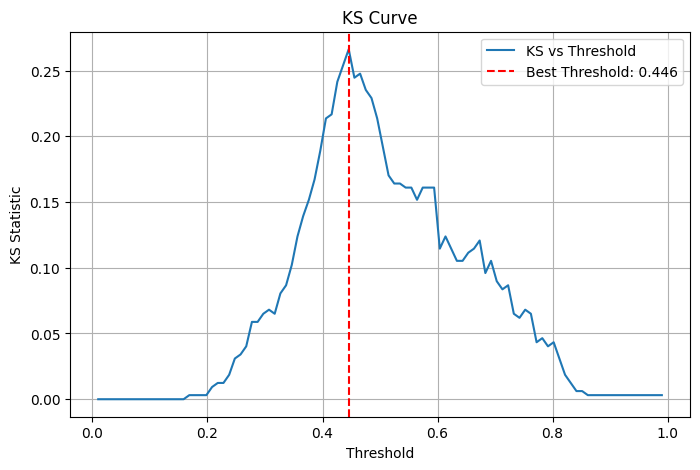

In [42]:
import numpy as np
from sklearn.metrics import confusion_matrix

def compute_ks(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr - fpr

thresholds = np.linspace(0.01, 0.99, 100)
ks_values = []

y_good = 1 - y_under

y_pred_prob = model.predict_proba(X_under.drop(columns=['BAD']))[:,1] 

for delta in thresholds:
    y_good_pred = 1 - (y_pred_prob >= delta).astype(int)
    ks = compute_ks(y_good, y_good_pred)
    ks_values.append(ks)

ks_values = np.array(ks_values)
best_index = np.argmax(ks_values)
best_threshold = thresholds[best_index]
best_ks = ks_values[best_index]

print(f"Best KS: {best_ks:.3f} at Threshold: {best_threshold:.3f}")

plt.figure(figsize=(8,5))
plt.plot(thresholds, ks_values, label='KS vs Threshold')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('KS Statistic')
plt.title('KS Curve')
plt.legend()
plt.grid()
plt.show()

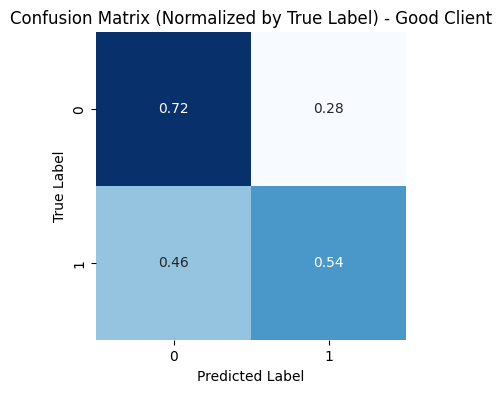

In [43]:
# Confusion matrix

y_good_pred = 1 - (y_pred_prob >= best_threshold).astype(int)

cm = confusion_matrix(y_good, y_good_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(4, 4))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Normalized by True Label) - Good Client')
plt.show()

## 📌 Rating Scale (RESOLUTION BCB Nº 2682) – Overview

The **Rating Scale** defiend in BCB Nº 2682 classifies customers into clear risk categories based on their predicted probability of default.

### ✅ How It Works
- Each client receives a **Client_score**:

- Higher scores indicate lower predicted risk.

- Customers are split into two groups:
- **Good**: historically low default risk
- **Bad**: historically high default risk

- Clustering (KMeans) is used to define natural score bands:
- **Good:** 3 ratings → AA, A, B
- **Bad:** 6 ratings → C, D, E, F, G, H

---

### ✅ Rating Interpretation

⭐ **Good Customers**
| Rating | Meaning                       |
|--------|-------------------------------|
| AA     | Excellent, lowest risk        |
| A      | Very good, low risk           |
| B      | Good, manageable risk         |

⭐ **Bad Customers**
| Rating | Meaning                       |
|--------|-------------------------------|
| C      | Moderate risk within Bad group |
| D      | High risk                     |
| E      | Elevated risk                 |
| F      | Very high risk                |
| G      | Extremely high risk           |
| H      | Highest risk, lowest score    |

---

### ✅ Purpose and Benefits
- Simplifies risk assessment with clear, interpretable categories.
- Supports credit decision-making and risk-based pricing.
- Enables targeted strategies for approval, pricing, and collections.

  


In [44]:
# Resolução 2682
from sklearn.cluster import KMeans
import pandas as pd

X_under['Client_score'] = 10 * (1 - y_pred_prob)
X_under['GOOD'] = y_good_pred

rating_scale = pd.DataFrame([])
dict_good = {'Good': 1, 'Bad': 0} 

X_new = pd.DataFrame([])

for val in dict_good:
    aux = X_under[X_under['GOOD'] == dict_good[val]].copy()

    if val == 'Good':
        n_clusters = 3
        labels_list = ['AA', 'A', 'B']
    else:
        n_clusters = 6
        labels_list = ['C', 'D', 'E', 'F', 'G', 'H']
    
    # Fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(aux[['Client_score']])
    aux['cluster'] = kmeans.labels_
    
    # Summarize stats for each cluster
    rating = []
    for c in aux['cluster'].unique():
        aux_c = aux[aux['cluster'] == c]
        rating.append({
            'cluster': c,
            'MIN': aux_c['Client_score'].min(),
            'MAX': aux_c['Client_score'].max(),
            'Average': aux_c['Client_score'].mean()
        })

    # Create DataFrame and sort by average score
    rating_df = pd.DataFrame(rating).sort_values(by='Average', ascending=False).reset_index(drop=True)
    
    # Assign rating labels in order of descending average
    rating_df['Rating'] = labels_list

    # Build mapping for this segment only
    cluster_to_rating = dict(zip(rating_df['cluster'], rating_df['Rating']))
    
    # Map to data
    aux['Rating'] = aux['cluster'].map(cluster_to_rating)
    
    # Append to final combined DataFrames
    rating_scale = pd.concat([rating_scale, rating_df], ignore_index=True)
    X_new = pd.concat([X_new, aux], ignore_index=True)

# Final result
rating_scale



,cluster,MIN,MAX,Average,Rating
0,2,7.011834,8.414116,7.419583,AA
1,1,6.219235,6.951425,6.552235,A
2,0,5.553389,6.205936,5.880375,B
3,2,5.110520,5.526166,5.334321,C
4,4,4.654777,5.103410,4.874434,D
5,5,4.093021,4.635173,4.398674,E
6,0,3.361382,4.081877,3.773697,F
7,3,2.501147,3.312383,2.929196,G
8,1,0.013759,2.451182,2.002236,H
